In [1]:
import ipywidgets as widgets

tiff_path = widgets.Text(
    value = 'C:\\Users\\inst\\Documents\\GitHub\\image_segmentation\\data\\',
    placeholder='Type something',
    description='tiff stack:',
    disabled=False
)

display(tiff_path)

Text(value='C:\\Users\\inst\\Documents\\GitHub\\image_segmentation\\data\\', description='tiff stack:', placeh…

In [2]:
%matplotlib inline
import vtk

tiff_reader = vtk.vtkTIFFReader()
tiff_reader.SetFileName(tiff_path.value)
tiff_reader.Update()


In [3]:
import tools
import numpy as np
from vtk.numpy_interface import dataset_adapter as dsa

vtkImage = tiff_reader.GetOutput()
dim = vtkImage.GetDimensions()
wrap = dsa.WrapDataObject(vtkImage)
stack = wrap.PointData['Tiff Scalars'].reshape(dim,order='F')
mean_z_intensity = np.mean(stack, axis = (0,1))

cropped,chg_pt = tools.crop_cone(mean_z_intensity,20,20)

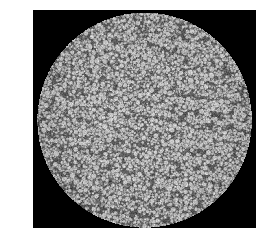

In [4]:
import matplotlib.pyplot as plt
plt.imshow(stack[:, :, 100],cmap='gray')
plt.axis('off')
plt.show()

In [5]:
bd = vtkImage.GetExtent()
voi = [bd[0],bd[1],bd[2],bd[3],int(chg_pt[0]+20),int(chg_pt[1]-20)]
crop_image = vtk.vtkExtractVOI()
crop_image.SetVOI(voi)
crop_image.SetInputConnection(tiff_reader.GetOutputPort())
crop_image.SetSampleRate(1,1,1)
crop_image.Update()

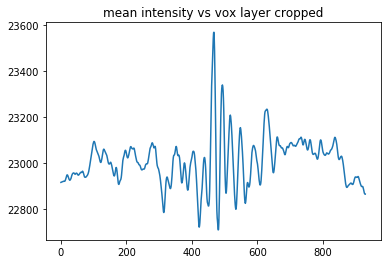

In [ ]:
fig, ax = plt.subplots()
ax.set_title('mean intensity vs vox layer cropped')
ax.plot(cropped)
plt.show()

In [ ]:
from sklearn.neighbors import KernelDensity

sensitivity_num = 2
offset_range = np.linspace(-0.20,0.20,sensitivity_num)
fig, axes = plt.subplots(sensitivity_num, 1, sharex=True)

for i in range(offset_range.size):
    offset = offset_range[i]
    ax = axes[i]
    res = tools.filter_otsu(crop_image.GetOutput(),offset)
    network = tools.particle_sizer(res,0.4)
    equiv_dia = network['network | net_01 | properties | pore.equivalent_diameter']
    
    x_plot = np.linspace(0,80,100)
    kde = KernelDensity(kernel='gaussian', bandwidth=0.75).fit(equiv_dia.reshape(-1,1))
    log_den = kde.score_samples(x_plot.reshape(-1,1))
    
    ax.set_title(offset)
    ax.plot(x_plot,np.exp(log_den))

plt.show()